# Review analysis to find potential improvement for customer satisfacition

The general idea is to analyse hotel reviews to find negative topics for which can be used to improve customer satisfaction. 

We will explore two ways:

1. First we analyse the whole data set and evaluate how good the topics are and check if the sentiment is negative.
2. Train a sentiment model to classify the reviews into positive and complaints and perform LDA afterwards.

The hypothesis is that the first approach will provide more general topics. When writing a positive review people tend to write more general, since everything was just nice. While when you complain about something since it was bad you will mention it more accurately in your review. 
Therefore, the second approach should provide more specific topics for the negative features of the hotels.

We have to be caution with the overall results because the dataset contains reviews for different hotels, resorts, and hostels from TripAdvisor hence the data is not really homogeneous which will add topics for different kind of hotels. 

## Structure

1. [Prerequisite and](#1.0)
2. [Data investigation](#2.0)
3. [First approach](#3.0)
    * [Model estimation](#3.1)
    * [Topic exploration](#3.2)
4. [Second approach](#4.0)

<a id='1.0'></a>
## 1.0 Prerequisite

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data processing
from LDA_preprocessing import *
from LDA_contextprocessing import *
from LDA_modelprocessing import *
from sentiment_functions import *
from sklearn.model_selection import train_test_split
from gensim.models import CoherenceModel
from afinn import Afinn

# Data Visualisation
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
import tqdm
%matplotlib inline
import sklearn as skt 

<a id='2.0'></a>
## 2.0 Data Preprocessing

In [2]:
#Load the data set
data_all = pd.read_csv("Data/tripadvisor_hotel_reviews.csv")
#data_all2 = pd.read_csv("Data/hotel-reviews.csv")

In [3]:
new_stopwords = ['hotel', 'room', 'stay', 'good', 'great', 'night', 'day', 'nice', 'time', 'pm', 'am', 'ft']

In [4]:
remove_stopwords = ['no', 'not']

In [7]:
data_all['clean_text'] = data_all['Review'].apply(text_normalization, args = (new_stopwords, []))
#data_all['clean_text_no'] = data_all['Review'].apply(lambda x: text_normalization(x))

In [8]:
data_all['Review'][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

In [9]:
data_all['clean_text'][2]

'experience monaco seattle level positive large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegative ac unit malfunction desk disorganize miss separate wakeup calls concierge busy hard touch provide guidance special request tv hard use ipod sound dock suite non function decided book mediterranean suite weekend first choice rest party fill comparison spend large square footage soak tub whirlpool jet shower arrange car service price tip reasonable driver wait arrival checkin easy downside pick person jacuzi tub bath accessory salt bubble bath get check voucher bottle champagne gesture fish waiting impression huge open space feel big tv far away bed chore change channel ipod dock break disappointing morning way ask desk check thermostat say degree warm try cover face bright blue light keep get first drop desk call maintainence come look thermostat tell play setting happy digital box wo work ask wakeup morning happen call later nap wakeup forgot wakeup m

In [7]:
data_all['clean_text_no'][2]

'nice room not experience hotel monaco seattle good hotel not level positive large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegative ac unit malfunction stay desk disorganize miss separate wakeup calls concierge busy hard touch not provide guidance special request tv hard use ipod sound dock suite non function decided book mediterranean suite night weekend stay first choice rest party fill comparison spend night large square footage room great soak tub whirlpool jet nice shower stay hotel arrange car service price tip reasonable driver wait arrival checkin easy downside room pick person jacuzi tub no bath accessory salt bubble bath not stay night get check voucher bottle champagne nice gesture fish waiting room impression room huge open space feel room big tv far away bed chore change channel ipod dock break disappointing morning way ask desk check thermostat say degree warm try cover face night bright blue light keep get room night no first drop 

In [12]:
af = Afinn()
# calculate number of tokens for each review
data_all['ntokens'] = data_all['clean_text'].str.split().str.len()

# Get Sentiment with textblob and affin
data_all['Sent_Blob'] = data_all['clean_text_no'].apply(lambda x: get_sent(x))
data_all['Sent_Afinn'] = [af.score(txt) for txt in data_all['clean_text_no']]

In [2]:
data_all.to_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\processed.json')
#data_all = pd.read_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\processed.json')

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id='2.0'></a>
## 2.0 Data investigation

In [42]:
data_all.head()

,Review,Rating,clean_text,clean_text_no,ntokens,Sent_Blob,Sent_Afinn,Polarity_Rating,Polarity_Blob,Polarity_Afinn
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...,nice hotel expensive parking get good deal sta...,79,0.187495,26.0,Positive,Positive,Positive
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,229,0.157204,31.0,Negative,Positive,Positive
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,nice room not experience hotel monaco seattle ...,193,0.287515,20.0,Neutral,Positive,Positive
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,82,0.504825,38.0,Positive,Positive,Positive
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay go seahawk game awesome ...,great stay great stay go seahawk game awesome ...,172,0.401923,32.0,Positive,Positive,Positive


In [6]:
data_all['clean_text'].count()

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


20491

In [21]:
data_all.query("ntokens>=10")
data_all.nsmallest(20, 'ntokens')

,Review,Rating,clean_text,clean_text_no,ntokens,Sent_Blob,Sent_Afinn
1501,"loved resort amazing space lot, not bored,",5,love resort amazing space lot bored,love resort amazing space lot not bored,6,0.450000,5.0
488,"issues n't say 4 star service great pool bar,",3,issue say star service great pool bar,issue not say star service great pool bar,7,0.800000,3.0
12823,hotel 9 10. hotel beach 7 10. beautiful sunset...,3,hotel beach beautiful sunset small beach area,hotel beach beautiful sunset small beach area,7,0.300000,3.0
18073,"nice hotel view second room room left row,",5,nice hotel view second room leave row,nice hotel view second room leave row,7,0.300000,2.0
17250,good gets best hotel carribean book weve booke...,5,good get good hotel carribean book beach stunning,good get good hotel carribean book beach stunning,8,0.633333,10.0
2332,big price small room price hype expect sooooo ...,3,big price small room price hype expect sooooo ...,big price small room price hype expect sooooo ...,9,0.027778,2.0
4524,"feeling cheated, westin signature comfy bed wi...",4,feel cheat westin signature comfy bed willing ...,feel cheat westin signature comfy bed willing ...,9,0.250000,-2.0
9969,"nice odd nice place stay, just buddies seeing ...",3,nice odd nice place stay buddy see paris good,nice odd nice place stay buddy see paris good,9,0.433333,7.0
10446,glad stayed great experience stay time steps p...,4,glad stay great experience stay time step pave...,glad stay great experience stay time step pave...,9,0.650000,6.0
13994,decent place stay price bed right bathroom max...,3,decent place stay price bed right bathroom max...,decent place stay price bed right bathroom max...,9,0.226190,0.0


 Lets take a first look at the numbers for the rating and the polarity.

In [16]:
data_all[data_all['ntokens'] <=50]['clean_text'].count()/data_all['clean_text'].count()*100

30.35967009906788

In [24]:
data_all.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,20491.0,3.952223,1.233030,1.000000,3.000000,4.00000,5.000000,5.0
ntokens,20491.0,96.968230,92.813903,6.000000,45.000000,72.00000,115.000000,1829.0
Sent_Blob,20491.0,0.265376,0.177418,-0.866667,0.169598,0.27254,0.374694,1.0
Sent_Afinn,20491.0,20.643990,18.605136,-53.000000,10.000000,18.00000,28.000000,324.0


In [66]:
data_all['Sent_Blob'].median()*1.2

0.32704761904761903

In [53]:
# Make a Polarity Rating where 3 = neutral, below negative and above positive
data_all['Polarity_Rating'] = data_all['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))
data_all['Polarity_Blob'] = data_all['Sent_Blob'].apply(lambda x: 'Positive' if x > data_all['Sent_Blob'].mean() else('Neutral' if x == data_all['Sent_Blob'].mean()  else 'Negative'))
data_all['Polarity_Afinn'] = data_all['Sent_Afinn'].apply(lambda x: 'Positive' if x > data_all['Sent_Afinn'].mean() else('Neutral' if x == data_all['Sent_Afinn'].mean()  else 'Negative'))

In [57]:
# Make a Polarity Rating where 3 = neutral, below negative and above positive
data_all['Polarity_Rating'] = data_all['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))
data_all['Polarity_Blob'] = data_all['Sent_Blob'].apply(lambda x: 'Positive' if x > 0 else('Neutral' if x == 0  else 'Negative'))
data_all['Polarity_Afinn'] = data_all['Sent_Afinn'].apply(lambda x: 'Positive' if x > 0 else('Neutral' if x == 0  else 'Negative'))

In [67]:
# Make a Polarity Rating where 3 = neutral, below negative and above positive
data_all['Polarity_Rating'] = data_all['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))
data_all['Polarity_Blob'] = data_all['Sent_Blob'].apply(lambda x: 'Positive' if x > data_all['Sent_Blob'].median()*1.2 else('Neutral' if (x <= data_all['Sent_Blob'].median()*1.2) & (x >= data_all['Sent_Blob'].median()*0.8)  else 'Negative'))
data_all['Polarity_Afinn'] = data_all['Sent_Afinn'].apply(lambda x: 'Positive' if x > data_all['Sent_Afinn'].median()*1.2 else('Neutral' if (x <= data_all['Sent_Afinn'].median()*1.2) & (x >= data_all['Sent_Afinn'].median()*0.8)  else 'Negative'))

In [69]:
# Make a Polarity Rating where 3 = neutral, below negative and above positive
data_all['Polarity_Rating'] = data_all['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))
data_all['Polarity_Blob'] = data_all['Sent_Blob'].apply(lambda x: 'Positive' if x > data_all['Sent_Blob'].mean()*1.2 else('Neutral' if (x <= data_all['Sent_Blob'].mean()*1.2) & (x >= data_all['Sent_Blob'].mean()*0.8)  else 'Negative'))
data_all['Polarity_Afinn'] = data_all['Sent_Afinn'].apply(lambda x: 'Positive' if x > data_all['Sent_Afinn'].mean()*1.2 else('Neutral' if (x <= data_all['Sent_Afinn'].mean()*1.2) & (x >= data_all['Sent_Afinn'].mean()*0.8)  else 'Negative'))

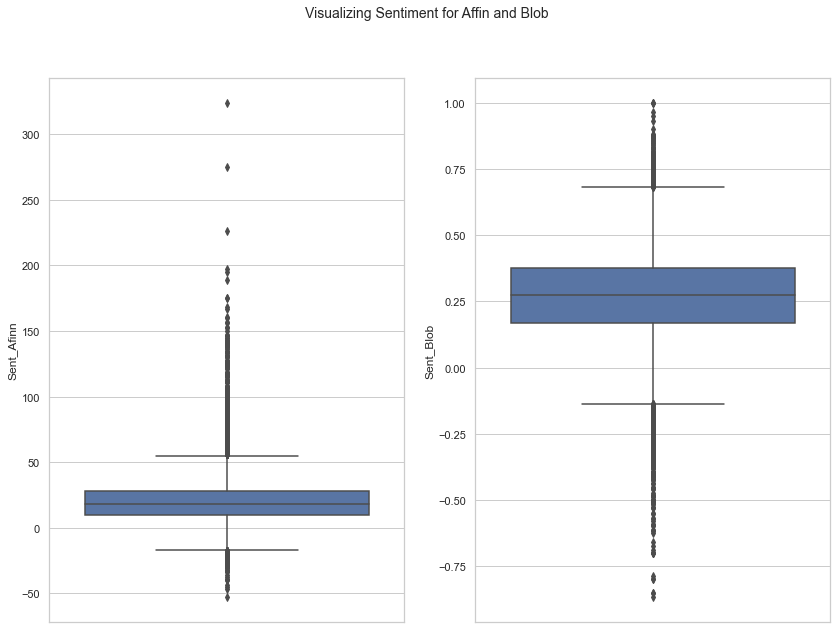

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
sp = sns.boxplot(y = data_all['Sent_Afinn'], ax=ax1)
bp = sns.boxplot(y = data_all['Sent_Blob'], ax=ax2)
t = f.suptitle('Visualizing Sentiment for Affin and Blob', fontsize=14)

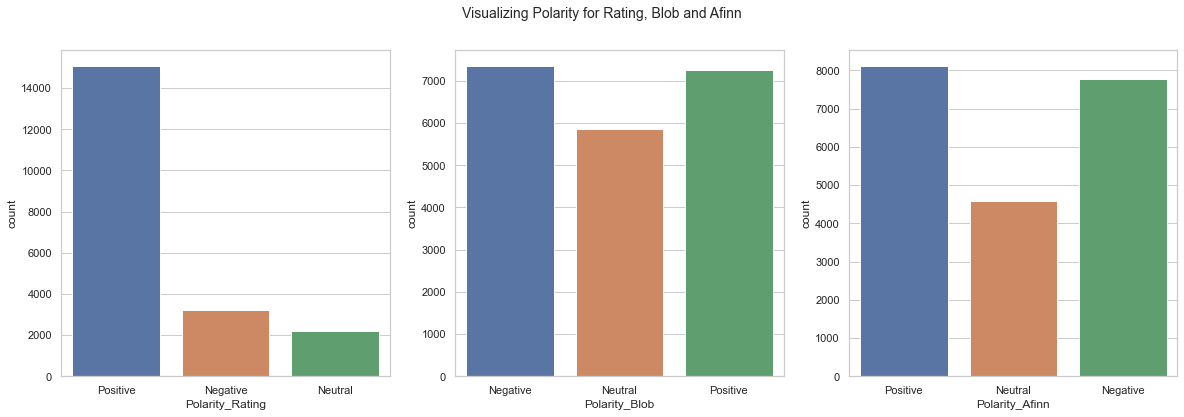

In [68]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
sp = sns.countplot(x = data_all['Polarity_Rating'], ax=ax1)
bp = sns.countplot(x = data_all['Polarity_Blob'], ax=ax2)
bt = sns.countplot(x = data_all['Polarity_Afinn'], ax=ax3)
t = f.suptitle('Visualizing Polarity for Rating, Blob and Afinn', fontsize=14)

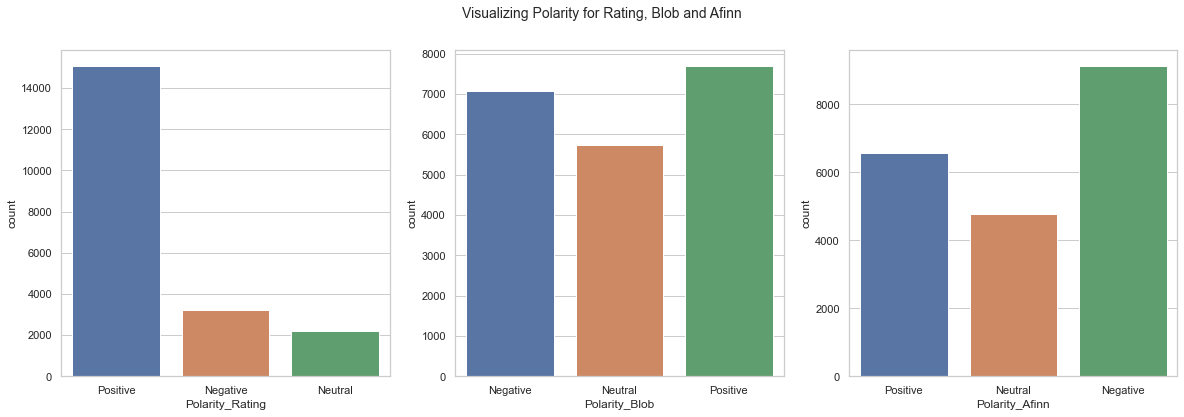

In [70]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
sp = sns.countplot(x = data_all['Polarity_Rating'], ax=ax1)
bp = sns.countplot(x = data_all['Polarity_Blob'], ax=ax2)
bt = sns.countplot(x = data_all['Polarity_Afinn'], ax=ax3)
t = f.suptitle('Visualizing Polarity for Rating, Blob and Afinn', fontsize=14)

The different polarity will be analysied later in more depth

Lets check out the most common words and add them to the stopwords

In [152]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [82]:
doc1 = [nlp(doc) for doc in data_all['clean_text']]

In [138]:
def wordFrequ(doc_r):
    word_frequencies = {}
    for doc in doc_r:
        for word in doc:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1
        maximum_frequency = max(word_frequencies.values())
        #for word in word_frequencies.keys():  
        #    word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
    return word_frequencies

In [140]:
word_freq_vec = wordFrequ(doc1)

In [146]:
word_freq_vec = pd.DataFrame([word_freq_vec]).T

In [153]:
word_freq_vec.nlargest(40, 0)

,0
hotel,52745
room,46528
stay,27301
good,21765
great,21491
staff,16669
night,13666
day,13012
nice,12973
time,11847


In [155]:
word_freq_vec.count()

0    52265
dtype: int64

In [157]:
word_freq_vec[word_freq_vec[0] > 10].count()

0    7658
dtype: int64

In [154]:
word_freq_vec.nsmallest(40, 0)

,0
chating,1
acheat,1
pillowsattentive,1
staffnegative,1
patten,1
palatte,1
humpin,1
besite,1
fantanne,1
joliet,1


In [59]:
data_all[data_all['ntokens'] <=50][['Rating_Polarity','clean_text']].groupby('Rating_Polarity').count()

KeyError: "['Rating_Polarity'] not in index"

In [15]:
# Showing the percantage of reviews with 50 tokens or less of the whole datased groupbed by polarity
data_all[data_all['ntokens'] <=50][['Rating_Polarity','clean_text']].groupby('Rating_Polarity').count()/len(data_all)*100

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,clean_text
Rating_Polarity,
Negative,3.289249
Neutral,2.498658
Positive,23.171148


Let's digg a bit deeper into each polarity and analyse the token lenght, so we can judge if there is a difference in token lenght for positive and negative reviews.

In [16]:
data_all[data_all['Rating_Polarity'] == 'Negative'].describe().T

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,25%,50%,75%,max
Rating,3214.0,1.557872,0.496717,1.0,1.0,2.0,2.0,2.0
n_characters,3214.0,737.154947,646.014303,66.0,352.0,552.5,892.0,7237.0
ntokens,3214.0,114.764157,100.036842,10.0,56.0,86.0,138.0,1042.0


In [17]:
data_all[data_all['Rating_Polarity'] == 'Positive'].describe().T

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,std,min,25%,50%,75%,max
Rating,15093.0,4.599881,0.489939,4.0,4.0,5.0,5.0,5.0
n_characters,15093.0,630.652620,603.439808,37.0,298.0,467.0,748.0,11207.0
ntokens,15093.0,95.661565,93.587380,7.0,44.0,70.0,113.0,1706.0


C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


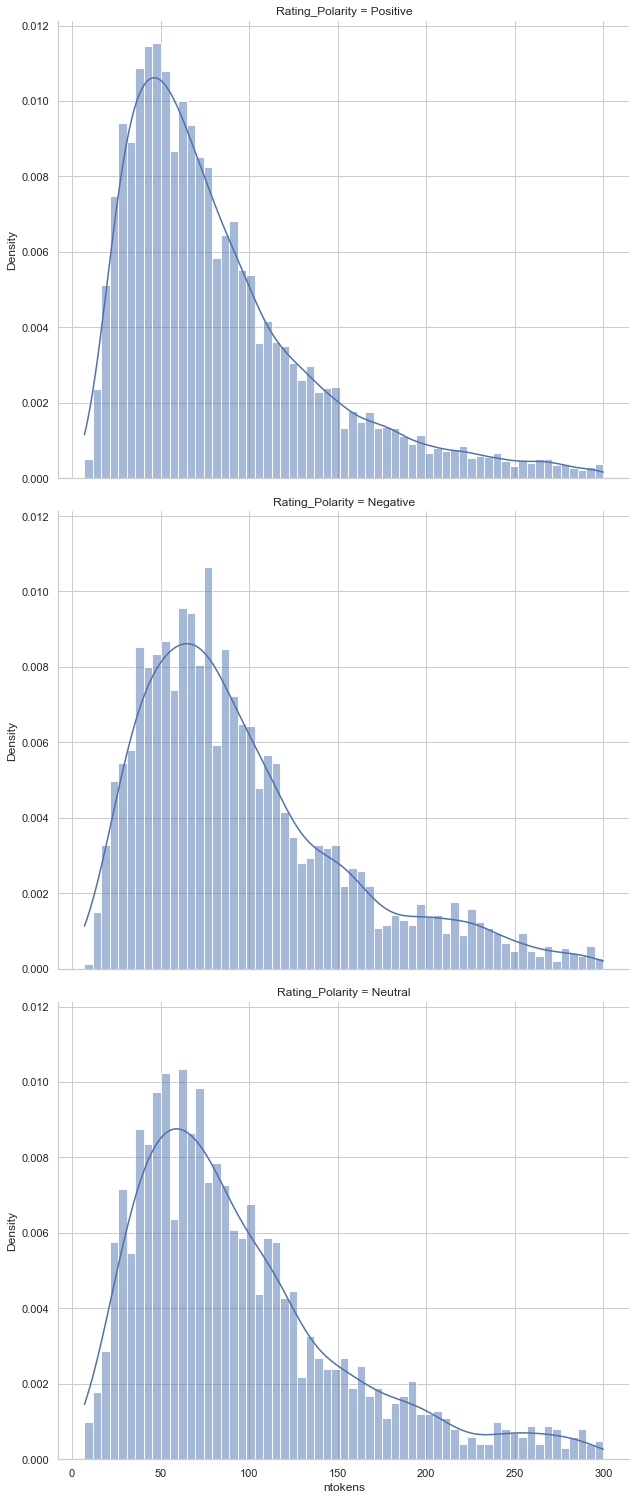

In [18]:
sns.set_theme(style="whitegrid")
sns.displot(
    data_all[data_all['ntokens'] <=300], x="ntokens",stat="density",  kde = True, row ='Rating_Polarity',common_norm=False,
    height=7, aspect=9/7)

The dataset contains 20491 reviews which we first analysed for their length. The reviews are mostly long with a mean of 104.37 tokens, including punctuations, and a median of 77. Even the minimum is at 7.0 tokens. Which is a good foundation since the Latent Dirichlet Allocation (LDA) performs good on medium or large sized texts compared to short texts (< 50 words). Where short Text Topic Models (STTM) as Gibbs Sampling Dirichlet Mixture Model (GSDMM) tend to perform better. In our case, roughly 27.29% of the reviews have 50 token or less. 

We have to make sure that the review length of the dataset is not too small when splitting the data into negative/positive and analysing them separately.
Our first results show, positive reviews tend to be shorter in the median (73.0) and average (99.488571) compared to negative (median: 90.0, average: 120.307094) ones. The standard deviation is also smaller indicating a support for the hypothesis that positive reviews are likely more general and standard.  

The proportion of the reviews having 50 token or less and being the negative is 11.22% (628). This accounts for 19.53% of the negative reviews from the whole dataset.
When doing the split on the dataset we have to keep the negative reviews, with 50 token or less, in mind and investigate if it yields better results dropping or keeping them, since they could be noisy to the LDA algorithm.

<a id='3.0'></a>
## 3. First approach

The first approach is to estimate the LDA model based on the whole data set. We split the dataset in train and test, where the test includes 5 reviews which will be unseen by the algorithm.

In [7]:
X_train, X_test = train_test_split(data_all[['Review', 'Rating','Rating_Polarity']], test_size=5, 
                                   random_state=1)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (20486, 3)
Test size: (5, 3)


<a id='3.1'></a>
### 3.1 Model Estimation

The calculation takes a bit of time!!

First we test the coherence score for bigram and trigram to evaluate the best semantic input. Afterwards, we estimate the LDA model with different hyperparameter for one of the semantic inputs.
Coherence measures the relative distance between words within a topic. We use the C_V coherence score which is typically 0 < x < 1.

The results of the calculation were saved in the coh_mat.json in the data subfolder since the calculation is computer intensive and taking time. Furthermore, the results are plotted in the graph below.

In [44]:
# Saving the coherence matrix for future use
#coh_mat.to_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\coh_mat.json')
coh_mat = pd.read_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\coh_mat.json')

In [32]:
coh_mat = pd.DataFrame(index=range(0,30),columns=['bi_gram', 'tri_gram'], dtype='float')
mod = ['bi_gram','tri_gram']

if 1 == 1:
    pbar = tqdm.tqdm(total=len(coh_mat)*len(mod))  
    for i in mod:
        results = lda_processing(data_all['clean_text'], model = i)
        corpus = results['text_corpus']
        id2word = results['id2word']


        for x in range(1, 30):
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= x,
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)
            cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
            coh_mat[i][x] = cm.get_coherence()
            pbar.update(1)
    pbar.close()

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
 97%|████████████████████████████████████████████████████████████████████████████▎  | 58/60 [4:18:00<08:53, 266.91s/it]


In [34]:
coh_mat

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bi_gram,tri_gram
0,NaN,NaN
1,-1.021044,-1.021044
2,-1.006431,-1.005675
3,-1.098699,-1.086255
4,-1.495757,-1.180709
5,-2.157471,-1.632835
6,-2.059280,-2.078698
7,-2.758848,-3.527017
8,-2.921378,-4.482262
9,-3.610297,-5.291858


In the following graph we can see that the highest coherence score (around 0.42) was achieved for the bi_gram model with 7 topics.

In general a coherence score of 0.42 is considered low. Which indicates that at least of the following things must be true:
1. The number of topics is still not ideal.
2. Fine-tuning the models Hyperparameter is still not optimal (alpha, random_state)
3. Or the data is not optimal / noisy.

These points we need to address later to achieve a score between 0.55 and 0.7 which is good. 

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


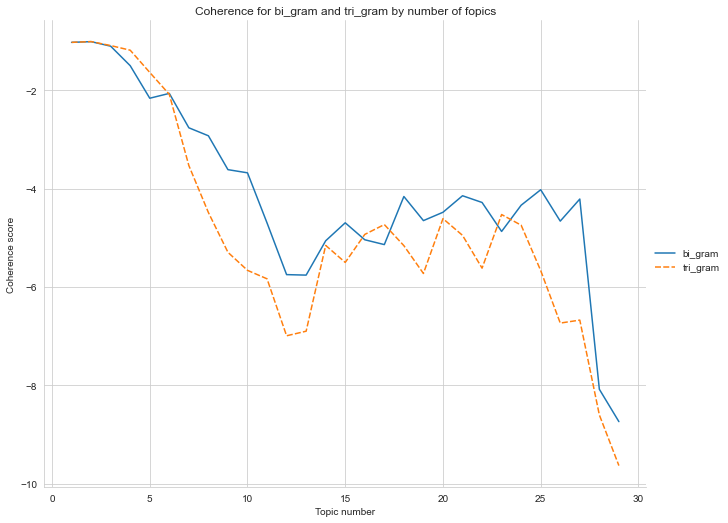

In [35]:
sns.relplot(data=coh_mat, kind="line", height=7, aspect=9/7)
plt.title("Coherence for bi_gram and tri_gram by number of fopics")
plt.ylabel("Coherence score")
plt.xlabel("Topic number")
sns.set_style('whitegrid')

In [10]:
results = lda_processing(data_all['clean_text'], model = 'tri_gram')

# Topics range
min_topics = 10
max_topics = 14
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.15))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.15))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
if 1 == 1:
    pbar = tqdm.tqdm(total=len(topics_range)*len(alpha)*len(beta))       
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus_c=results['text_corpus'], dictionary_c=results['id2word'], k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

        pbar.update(1)
    pbar.close()

  1%|█                                                                       | 4/288 [13:56:45<990:09:56, 12551.40s/it]


In [11]:
model_results

{'Topics': [10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,


In [12]:
df = pd.DataFrame(model_results)[pd.DataFrame(model_results)['Coherence'] == pd.DataFrame(model_results)['Coherence'].min()]
df

,Topics,Alpha,Beta,Coherence
126,11,0.91,0.91,-13.302927


In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=results['text_corpus'],
                                           id2word=results['id2word'],
                                           num_topics= 11,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta = 0.91,
                                           per_word_topics=True)

<a id='3.2'></a>
### 3.2 Topic exploration

We can visualize the different topics after calculating the model 

1. pyLDAvis is used to visualize the topics interactively.
2. Word Cloud for each topic.
3. Assigning topic names for each topic.

The pyLADvis graph shows the topics in a two-dimensional space. The lambda is a relevance parameter to adjust the weights given to a term in the topic. Setting lambda between 0.2 and 0.4 often helps to generate interpretable topics.

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, results['text_corpus'], results['id2word'])
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.299714 -0.161636       1        1  32.309300
9     -0.305545  0.079779       2        1  31.005650
6     -0.267602  0.087600       3        1  26.770430
5      0.109231 -0.000669       4        1   1.245452
8      0.109090 -0.000725       5        1   1.238608
10     0.109090 -0.000724       6        1   1.238487
3      0.109090 -0.000725       7        1   1.238472
7      0.109090 -0.000725       8        1   1.238419
0      0.109090 -0.000725       9        1   1.238410
1      0.109089 -0.000724      10        1   1.238407
4      0.109090 -0.000725      11        1   1.238365, topic_info=           Term         Freq        Total Category  logprob  loglift
5224      beach  8870.000000  8870.000000  Default  30.0000  30.0000
26     location  8285.000000  8285.000000  Default  29.0000  29.0000
1042       pool  7876.000000  7876.000000  Default  28.0000  28.0000
5168     resort  7581.000000  7581.000000  Default  27.0000  27.0000
443        food  8554.000000  8554.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
41626   palomar     2.073444    47.537101  Topic11  -9.2214   1.2591
7871   st_regis     2.570770   131.957886  Topic11  -9.0064   0.4531
52843    argent     2.315903   116.659851  Topic11  -9.1108   0.4719
17340    arctic     2.080141    57.685959  Topic11  -9.2182   1.0688
19964     mario     2.066504    88.293234  Topic11  -9.2247   0.6366

[844 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
52765      1  0.448247  academies
52765      2  0.034481  academies
52765      3  0.068961  academies
52765      4  0.068961  academies
52765      5  0.068961  academies
...      ...       ...        ...
52661      7  0.104891     zwolle
52661      8  0.104891     zwolle
52661      9  0.104891     zwolle
52661     10  0.104891     zwolle
52661     11  0.104891     zwolle

[1820 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 7, 6, 9, 11, 4, 8, 1, 2, 5])

## Following the project has to be updated in the next steps. 

IndexError: list index out of range

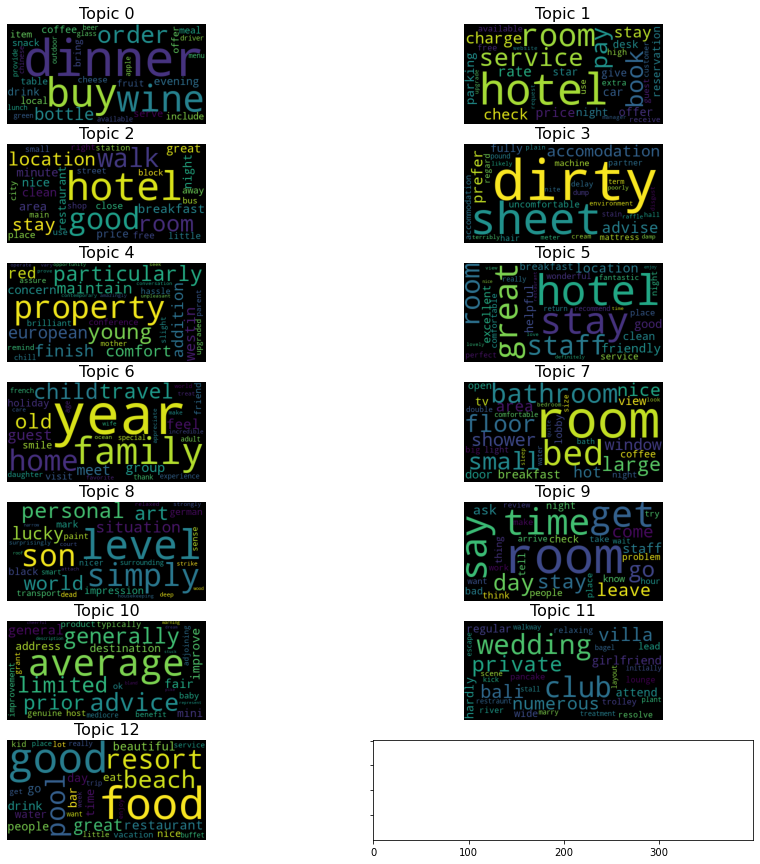

In [13]:
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=13, num_words=10, formatted=False)

fig, axes = plt.subplots(7, 2, figsize=(15,15),sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    plt.gca().imshow(WordCloud().fit_words(dict(lda_model.show_topic(i, 30))))
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [38]:
# Print all the topics

topics = []
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 15)
    topk_words = [ w for w, _ in topk ]
    topics.append([topic_id, ' '.join([ w for w, _ in lda_model.show_topic(topic_id, 10)])])
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))
topics = pd.DataFrame(topics, columns =['Topic_id', 'Topic_words'])

0: bathroomgreat mayfare trafalger fortnum harp occaision poundsnight selction shipping waterloo bac teatowel districtsoho realtionship thand
1: star wedding hand save tripadvisor woman privacy figure rating us plentiful brand_new buck unique cash
2: heavy bellhop embassy_suite miserable freight osaka dad passage corte_grimani studio shinjuku_station greek idle subpar rich
3: section twin rooftop nee result notch period update sunny hide create rare conclusion fixture partial
4: time good day food restaurant bar service great drink beautiful trip go eat really like
5: not room no get say day like ask think problem leave go check work night
6: alot internet_access flat_screen_tv wifi san_francisco length inroom theater unpleasant diner let_us criticism relate bart instance
7: hotel room stay great good staff nice clean location breakfast walk night area small friendly
8: bottle sun gorgeous boyfriend complete terrace wave plane fresh_fruit milk accommodation temperature tend load river


C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next we need to manually assign the topic names for each topic and then add the topics and their probabilities to each review.

In [40]:
#Manual assignment of the topics
topics = pd.DataFrame(topics, columns =['Topic_id', 'Topic_words'])
topics['Topic_name'] =['top1', 'top2', 'top3', 'top4', 'top5', 'top6', 'top7', 'top8','top9','top10','top11','top12']
topics

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_id,Topic_words,Topic_name
0,0,poundsnight occaision waterloo shipping selcti...,top1
1,1,star wedding hand save tripadvisor woman priva...,top2
2,2,heavy bellhop embassy_suite miserable freight ...,top3
3,3,section twin rooftop nee result notch period u...,top4
4,4,time good day food restaurant bar service grea...,top5
5,5,not room no get say day like ask think problem,top6
6,6,alot internet_access flat_screen_tv wifi san_f...,top7
7,7,hotel room stay great good staff nice clean lo...,top8
8,8,bottle sun gorgeous boyfriend complete terrace...,top9
9,9,superb class definately brilliant march sister...,top10


In [45]:
# Adding the probable topics to the data
data_all['top1'] = data_all['clean_text'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 0))
data_all['top1_prob'] = data_all['clean_text'].apply(lambda x: lda_get_prob(lda_model, x, topics, topic_order = 0))
#X_train['top2'] = X_train['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 1))
#X_train['top2_prob'] = X_train['Review'].apply(lambda x: lda_get_prob(lda_model, x, topics, topic_order = 1))
#X_train['top3'] = X_train['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 2))
#X_train['top3_prob'] = X_train['Review'].apply(lambda x: lda_get_prob(lda_model, x, topics, topic_order = 2))

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'pd' is not defined

In [18]:
X_train.head()

,Review,Rating,Rating_Polarity,top1,top1_prob
15901,exceed expectation tokyo vacation 4-13 october...,5,Positive,Location / Access,0.257747
3661,loved dominicana family 6 adults children ages...,4,Positive,Staff / Service,0.230389
2124,excellent choice stayed airport hilton night a...,5,Positive,Location / Access,0.344944
17544,wonderful stay midtown stayed 3 nights 4 days ...,5,Positive,Staff / Service,0.548587
82,"great stay elevators, agree previous posts hot...",5,Positive,Complaint handling,0.301715


C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


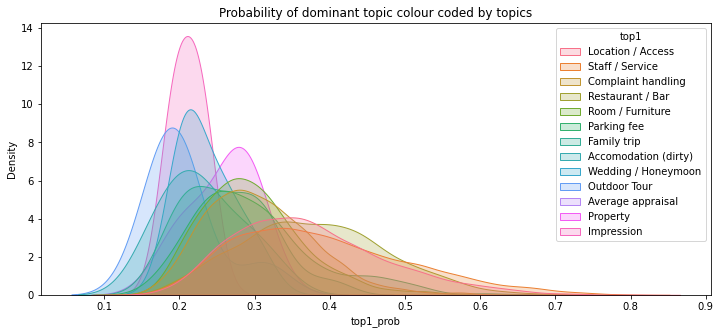

In [19]:
plt.figure(figsize=(12,5))
sns.kdeplot(data=X_train, x='top1_prob', hue='top1', shade=True, 
            common_norm=False)
plt.title("Probability of dominant topic colour coded by topics");

From this graph we can see, that the algorithm does not assign a high probability for the most probable topic. He is not so sure about the topic. We have 13 topics and the probability is not centred around a higher value. It leads to the conclusion that most of the topics are more general and therefore including several topics. 

In [68]:
X_train[X_train['Rating_Polarity'] == 'Negative'].loc[:, ['Review', 'top1']].groupby("top1").count()

,Review
top1,
Accomodation (dirty),7
Complaint handling,1292
Family trip,15
Location / Access,465
Parking fee,411
Restaurant / Bar,461
Room / Furniture,362
Staff / Service,200
Wedding / Honeymoon,1


In [69]:
X_train[X_train['Rating_Polarity'] == 'Negative'].loc[:, ['Review', 'top2']].groupby("top2").count()

,Review
top2,
Accomodation (dirty),19
Average appraisal,7
Complaint handling,960
Family trip,37
Impression,14
Location / Access,397
Outdoor Tour,15
Parking fee,587
Property,7


In [72]:
X_train[(X_train['Rating_Polarity'] == 'Negative') & (X_train['top1_prob'] == X_train['top2_prob'])]

,Review,Rating,Rating_Polarity,top1,top1_prob,top2,top2_prob,top3,top3_prob


C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


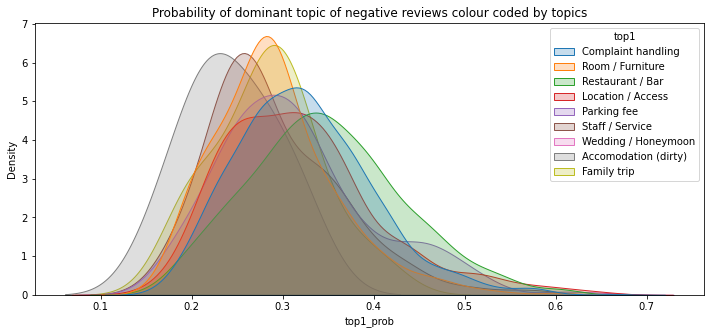

In [73]:
plt.figure(figsize=(12,5))
sns.kdeplot(data=X_train[X_train['Rating_Polarity'] == 'Negative'], x='top1_prob', hue='top1', shade=True, 
            common_norm=False)
plt.title("Probability of dominant topic of negative reviews colour coded by topics");

We can see the topics with the most negative reviews by showing the proportion of the topics from negative reviews of all negative reviews.
Where the graph indicates that overall the topics could be allocated a bit better since the probabilities shifted more to the right.

In [259]:
X_test

,Review,Rating,Rating_Polarity
15077,great location value cautious staying hotel lo...,5,Positive
2784,2nd trip paradisus 2nd time paradisus 10 year ...,4,Positive
5018,"best staff, husband stayed hotel casci nights,...",4,Positive
2741,honeymoon wife stayed week august 2001 honeymo...,4,Positive
8327,"perfect location location location location, w...",3,Neutral


In [22]:
X_test['Review'][2784]

"2nd trip paradisus 2nd time paradisus 10 year wedding anniversary, went riu years ago decided really wanted paradisus 2001, let start saying bahamas caymen islands hotel beautifully landscaped hotels, pool gorgeous plenty areas away, tucked away nooks place, people unbelievably friendly happy, no question language barrier country, quick tips good things disappointments, 1. arrive airport porters swarm bags, let bags carry feet want tip, thing return airport hotel, time insist carry bags feet.2, 2 times punta cana taken pepto tablets, morning just safe problems, time forgot bring antacid, 8 days day 7 got montazuma-it 2 days feeling affects, advice antacid tablets-i got bad heartburn day pepto tablet morning feel alright.3, got great advice reviewer bring chill cups drinks, got migo plastic chill cups straws target fewer trips beach bars 4, bring cork screw, ordered bottle wine room heading beach, wine returned no cork screw, room service got shower did n't leave, time got heading door

In [23]:
lda_get_topics(lda_model, X_test['Review'][2784], topics, topic_order = 0)

'Complaint handling'

In [24]:
lda_get_prob(lda_model, X_test['Review'][2784], topics, topic_order = 0)

0.2846112847328186

In [25]:
lda_get_topics(lda_model, X_test['Review'][2784], topics, topic_order = 1)

'Restaurant / Bar'

In [26]:
lda_get_prob(lda_model, X_test['Review'][2784], topics, topic_order = 1)

0.26967528462409973

In [27]:
lda_get_topics(lda_model, X_test['Review'][2784], topics, topic_order = 2)

'Room / Furniture'

In [28]:
lda_get_prob(lda_model, X_test['Review'][2784], topics, topic_order = 2)

0.07474282383918762

<a id='4.0'></a>
## 4. Second approach

In this approach we use the Rating_Polarity feature to separate the data and use only the negative to train the topic model.
First we use the whole negative dataset and check if the results differ when dropping the reviews with <50 tokens.

In [8]:
data_all['Review'][2]

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'nice hotel fight room good view view room finally got moved,  '

In [3]:
text_normalization(data_all['Review'][2], remove_digits = True)

C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'nice hotel fight room good view room finally get move'